# Prédiction de la direction des prix sur les marchés financiers


## 1. Introduction et présentation du problème



### 1.1 Contexte et enjeux

Dans le cadre de ce challenge (issu du Collège de France ou du Lab Banque de France), nous disposons de données de marché avec pour objectif de prédire la direction du prix (baisse, stable, hausse) en fin de journée, à partir des rendements du matin.

Ce marché américain étant particulièrement liquide, l'enjeu est de pouvoir estimer la tendance entre 14h et 16h pour prendre des décisions d'investissement ou d'arbitrage.



### 1.2 Description des données

- **Index des données**
  - Chaque ligne représente un jour donné et une action donnée (identifiants : `day` et `equity`).
  - Les colonnes `r0` à `r52` correspondent aux rendements (en points de base) toutes les 5 minutes entre 9h30 et 14h.

- **Variables explicatives**
  - Les 53 rendements (`r0, r1, …, r52`), éventuellement d'autres features dérivées.

- **Variable cible**
  - `reod` {-1, 0, 1} indiquant la tendance de l'actif entre 14h et 16h (baisse, stable ou hausse).



### 1.3 Problématique et défis

Notre mission est de prédire la classe de rendement (`reod`) en fin de journée, à partir des données matinales. Les défis principaux sont :

- La **taille importante** du dataset (plusieurs centaines de milliers de lignes).
- La **présence de valeurs manquantes** (`NaN`).
- L'**absence de jours/actions communs** entre le jeu d'entraînement et le jeu de test, ce qui complique l'utilisation directe de `equity` ou `day` en tant que features.
- Le **risque de surcoût mémoire** et de temps de calcul avec certains modèles comme les Random Forest.



## 2. Exploration des données (EDA)


### 2.1 Aperçu des données et analyse des valeurs manquantes

Nous commençons par explorer les données d'entraînement pour comprendre leur structure et la distribution des valeurs manquantes.


### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

### Importation des données

In [2]:

# Importation des données d'entraînement
X = pd.read_csv('input_training.csv')
X.sort_values(by="ID",inplace=True)
y = pd.read_csv('output/output_training_gmEd6Zt.csv')

# Importation des données de test
data_test = pd.read_csv('input_test.csv')
data_test.sort_values(by="ID",inplace=True)
y_test = pd.read_csv("output/output_test_random.csv")

# Fusion des données et labels
X_train = pd.merge(X, y, on="ID").copy()
data_test.sort_values(by="ID", inplace=True)
X_test = pd.merge(data_test, y_test, on="ID").copy()

# Aperçu des données
print("\n--- Aperçu des données d'entraînement ---")
print(f"Nombre de lignes train: {X_train.shape[0]}, Nombre de colonnes: {X_train.shape[1]}")
print(f"Nombre de lignes test: {X_test.shape[0]}, Nombre de colonnes: {X_test.shape[1]}")
print("\nPremières lignes:")
display(X_train.head())


--- Aperçu des données d'entraînement ---
Nombre de lignes train: 843299, Nombre de colonnes: 57
Nombre de lignes test: 885799, Nombre de colonnes: 57

Premières lignes:


,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r44,r45,r46,r47,r48,r49,r50,r51,r52,reod
0,0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00,0
1,1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,...,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68,0
2,2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,...,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96,-1
3,3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0
4,4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,...,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43,-1


### Analyse des valeurs manquantes 

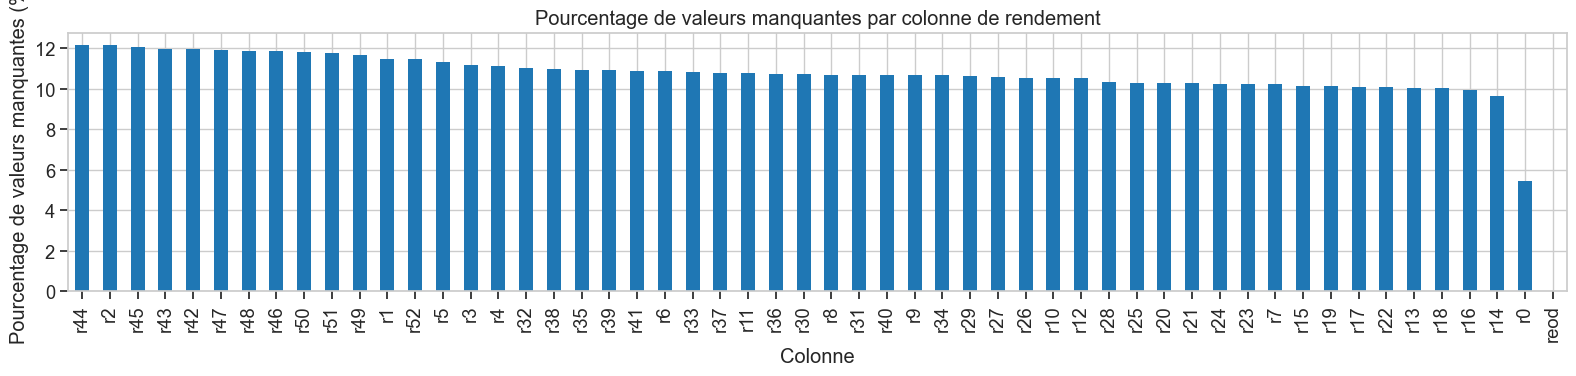

In [57]:
col_rendements = [col for col in X_train.columns if col.startswith("r")]
# Analyse du nombre de valeurs manquantes par colonne
plt.figure(figsize=(16, 4))

missing_values_count = X_train[col_rendements].isna().sum()
missing_values_percent = (missing_values_count / len(X_train)) * 100
missing_df = pd.DataFrame({
    'Nombre de NaN': missing_values_count,
    'Pourcentage (%)': missing_values_percent
}).sort_values('Nombre de NaN', ascending=False)

ax = missing_df['Pourcentage (%)'].plot.bar()
plt.title('Pourcentage de valeurs manquantes par colonne de rendement')
plt.ylabel('Pourcentage de valeurs manquantes (%)')
plt.xlabel('Colonne')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

Nombre de lignes totales du dataset: 843299
Nombre de lignes contenant au moins un NaN: 242363, soit 28.74%
Nombre de lignes avec plus de 30% de NaN: 121123, soit 14.36%
Nombre de lignes avec plus de 50% de NaN: 77034, soit 9.13%


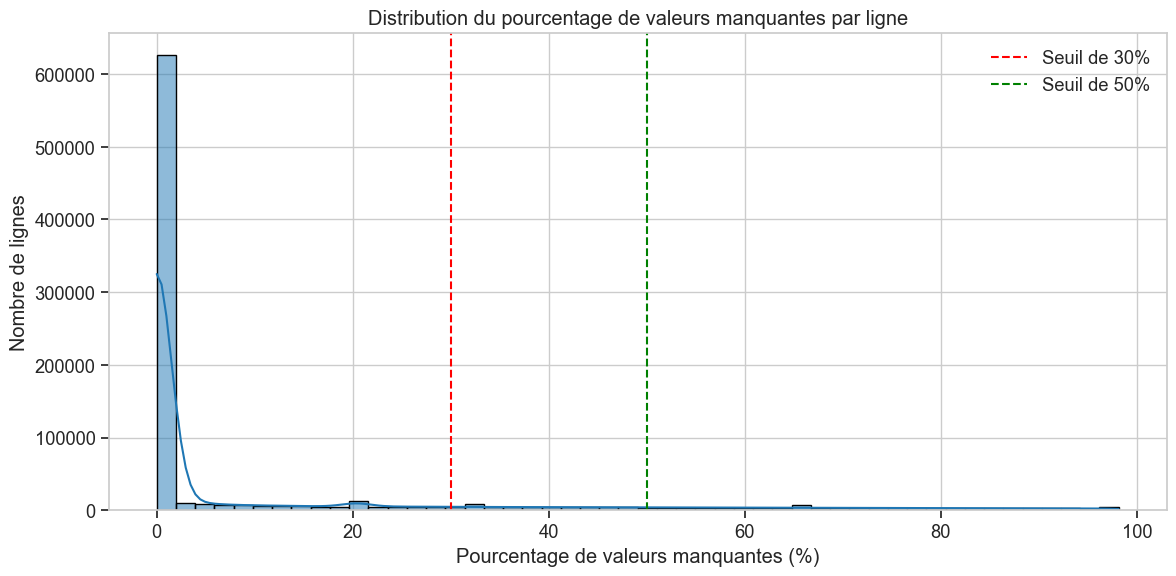

In [58]:
# Analyse du nombre de valeurs manquantes par ligne
NaN_analysis = pd.DataFrame(index=X_train.index, columns=["NaN_count", "NaN_percent"])
NaN_analysis["NaN_count"] = X_train[col_rendements].isna().sum(axis=1)
nombre_colonnes_rend = len(col_rendements)
NaN_analysis["NaN_percent"] = (NaN_analysis["NaN_count"] / nombre_colonnes_rend) * 100

# Compter le nombre de lignes avec des NaN
nbr_row_na = X_train.isna().any(axis=1).sum()

print(f"Nombre de lignes totales du dataset: {len(X_train)}")
print(f"Nombre de lignes contenant au moins un NaN: {nbr_row_na}, soit {(nbr_row_na/len(X_train)*100):.2f}%")
print(f"Nombre de lignes avec plus de 30% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>30])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>30])/len(X_train)*100:.2f}%")
print(f"Nombre de lignes avec plus de 50% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>50])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>50])/len(X_train)*100:.2f}%")

plt.figure(figsize=(12, 6))
sns.histplot(NaN_analysis["NaN_percent"], bins=50, kde=True)
plt.title('Distribution du pourcentage de valeurs manquantes par ligne')
plt.xlabel('Pourcentage de valeurs manquantes (%)')
plt.ylabel('Nombre de lignes')
plt.axvline(x=30, color='r', linestyle='--', label='Seuil de 30%')
plt.axvline(x=50, color='g', linestyle='--', label='Seuil de 50%')
plt.legend()
plt.tight_layout()
plt.show()

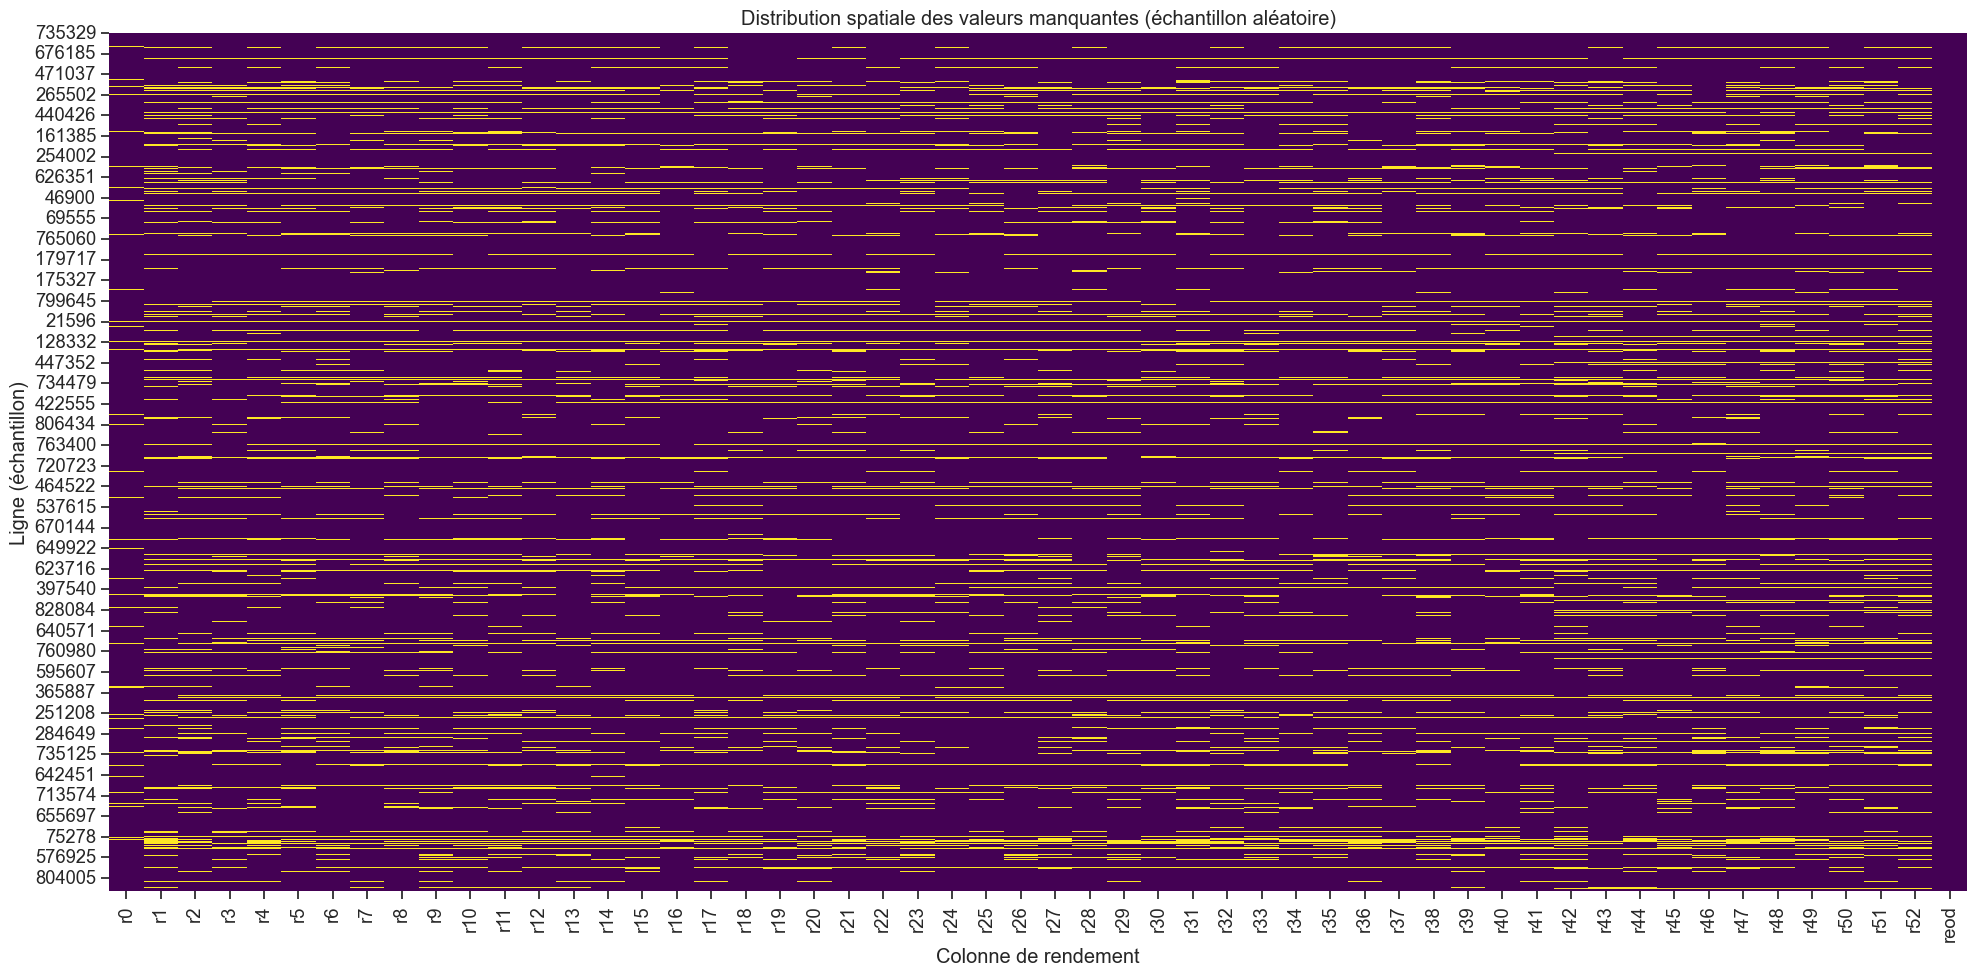

In [59]:
# Distribution spatiale des NaN (heatmap)
plt.figure(figsize=(20, 10))
sample_size = min(1000, len(X_train))  # Limiter à 1000 lignes pour la lisibilité
sample_indices = np.random.choice(range(len(X_train)), sample_size, replace=False)
sample_data = X_train.iloc[sample_indices][col_rendements].isna()
sns.heatmap(sample_data, cbar=False, cmap='viridis')
plt.title('Distribution spatiale des valeurs manquantes (échantillon aléatoire)')
plt.xlabel('Colonne de rendement')
plt.ylabel('Ligne (échantillon)')
plt.tight_layout()
plt.show()


### 2.2 Distribution des rendements

Analysons la distribution des rendements pour identifier d'éventuelles caractéristiques ou anomalies.


In [60]:
col_rendements.remove("reod")

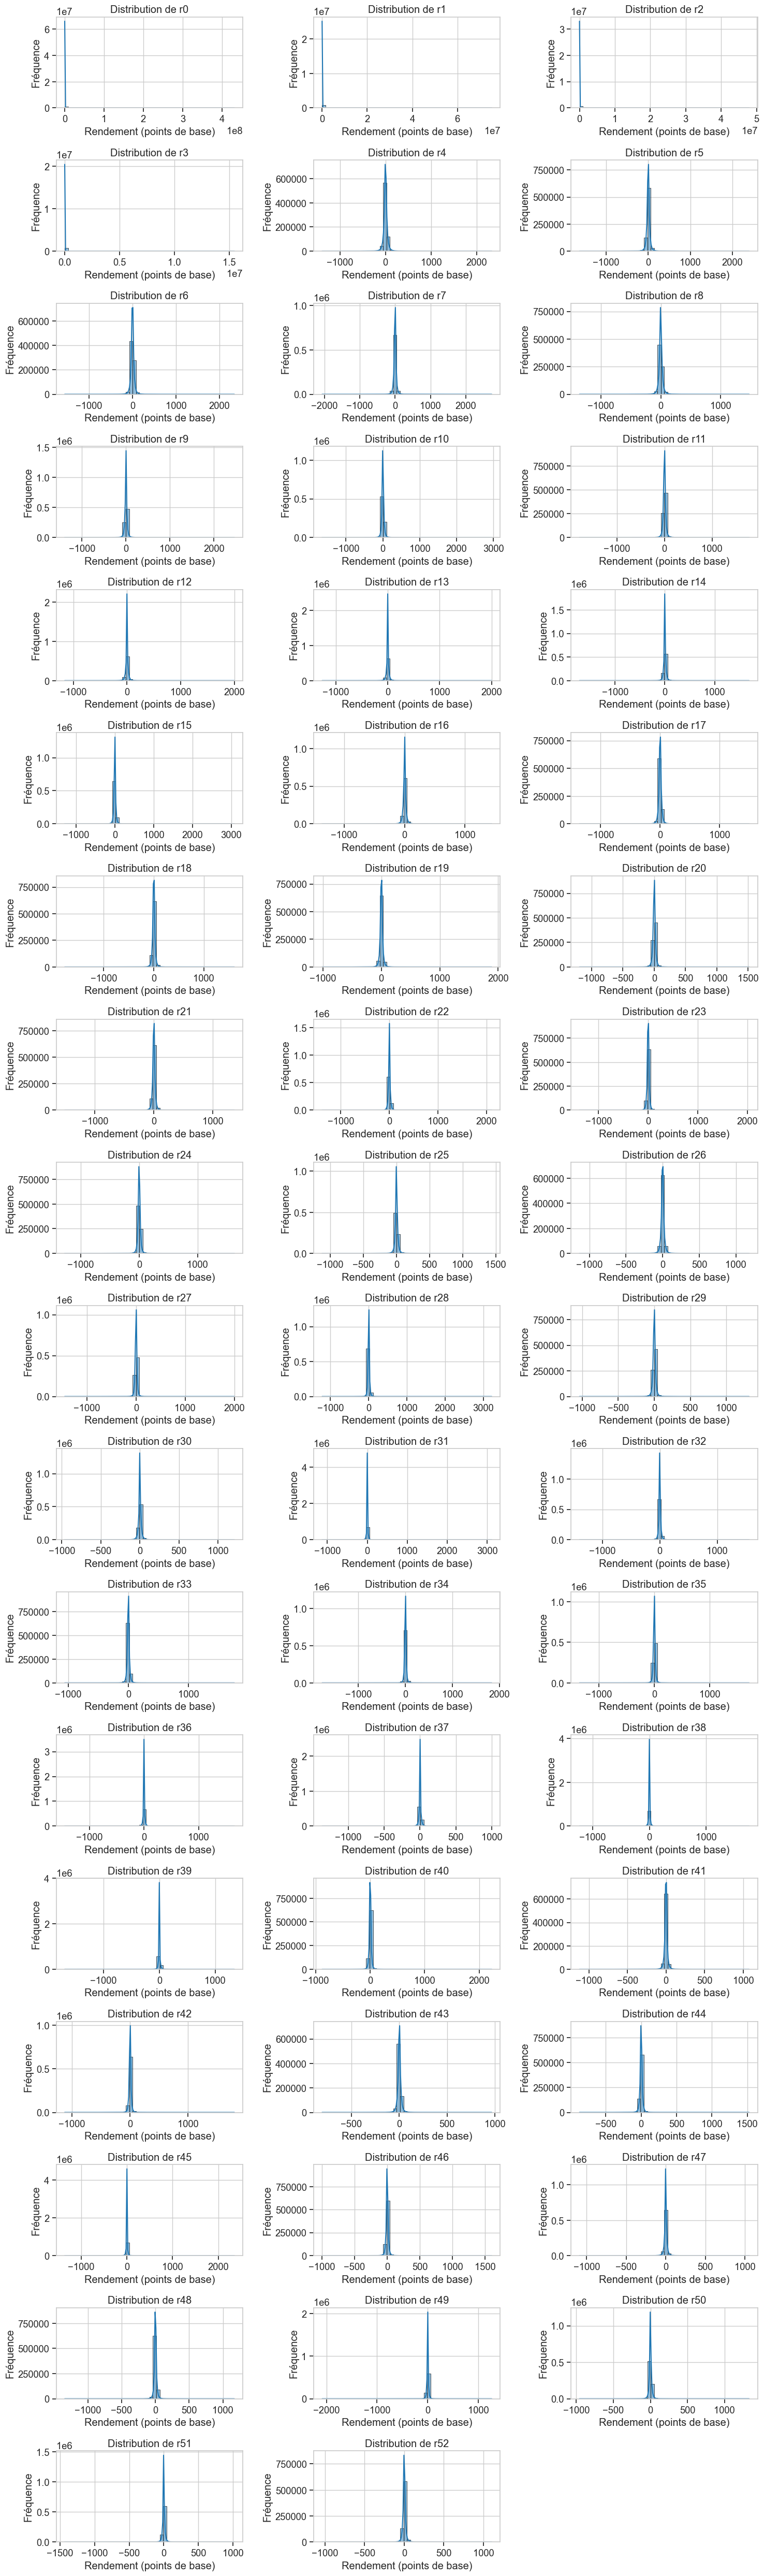

In [61]:
plt.figure(figsize=(15, 50))

for i, col in enumerate(col_rendements):
    plt.subplot(int(len(col_rendements)/3) + 1, 3, i+1)
    sns.histplot(X_train[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

In [62]:
rendements_stats = X_train[col_rendements].describe().T
rendements_stats['missing_percent'] = X_train[col_rendements].isna().mean() * 100
rendements_stats = rendements_stats.sort_values('max', ascending=False)
rendements_stats.head(10)

,count,mean,std,min,25%,50%,75%,max,missing_percent
r0,797476.0,1839.874545,609754.773378,-9967.67,-30.58,0.0,21.34,4.310700e+08,5.433779
r1,746484.0,193.534369,115327.121385,-9973.54,-21.10,0.0,20.71,7.516000e+07,11.480507
r2,740829.0,70.113991,55888.225790,-4823.74,-17.60,0.0,16.51,4.789000e+07,12.151088
r3,749130.0,19.564481,17850.550113,-1949.69,-17.47,0.0,15.17,1.545000e+07,11.166739
r28,756012.0,-0.270700,24.155237,-1219.51,-7.43,0.0,6.91,3.217820e+03,10.350659
r31,753271.0,-0.098791,23.342380,-1131.26,-6.66,0.0,6.54,3.114750e+03,10.675692
r15,757907.0,-0.625162,29.575757,-1290.32,-10.18,0.0,8.68,3.076920e+03,10.125946
r10,754488.0,0.372729,33.535457,-1647.06,-10.15,0.0,10.76,2.951810e+03,10.531377
r7,757167.0,-1.195195,38.327389,-2066.67,-13.76,0.0,11.44,2.733810e+03,10.213696
r9,753369.0,0.405408,34.341933,-1390.42,-10.34,0.0,11.25,2.462310e+03,10.664071


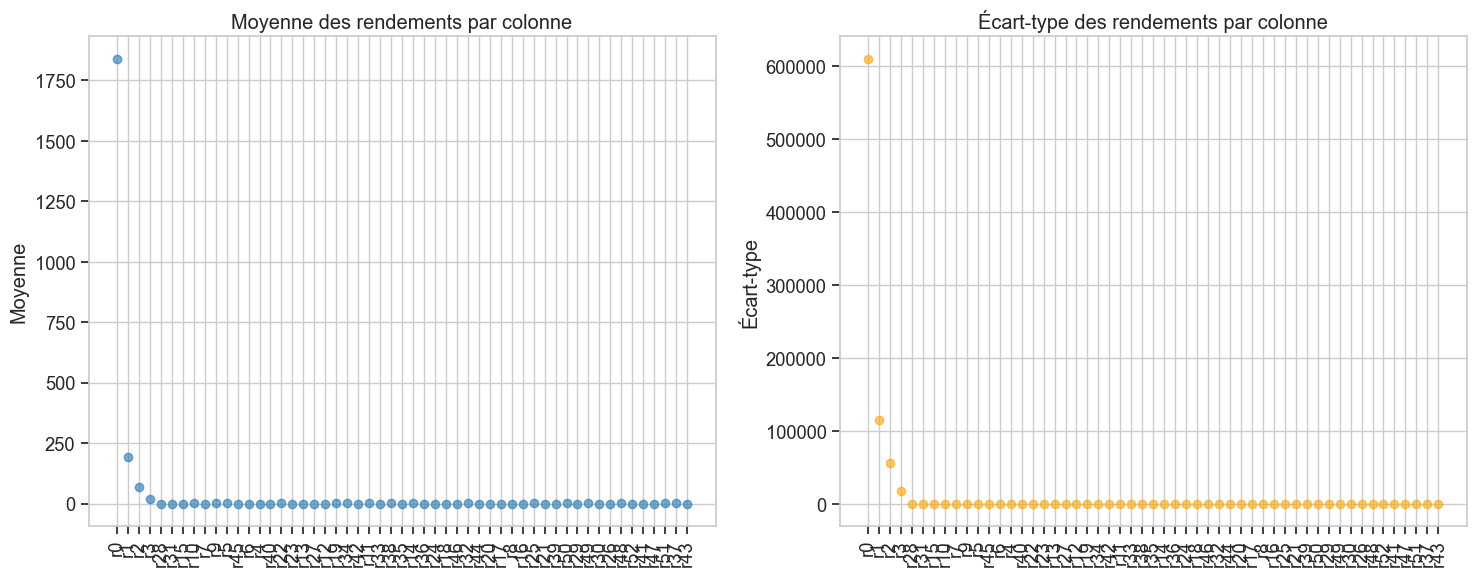

In [63]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(rendements_stats.index, rendements_stats['mean'], alpha=0.6)
plt.title('Moyenne des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Moyenne')

plt.subplot(1, 2, 2)
plt.scatter(rendements_stats.index, rendements_stats['std'], alpha=0.6, color='orange')
plt.title('Écart-type des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Écart-type')
plt.tight_layout()
plt.show()


### 2.3 Analyse de la variable cible

Examinons la distribution de notre variable cible `reod` pour vérifier l'équilibre entre les classes.


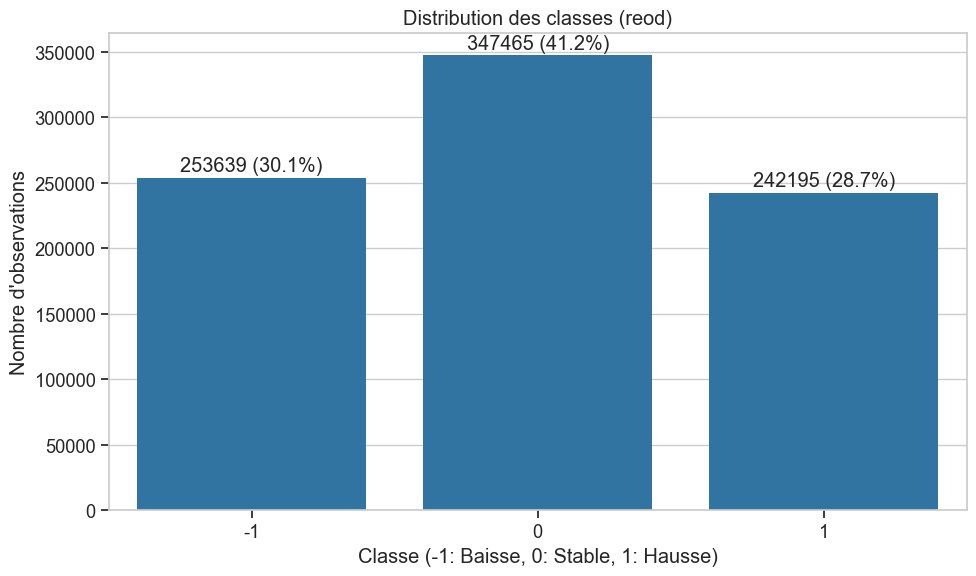

In [64]:
# Distribution des classes
plt.figure(figsize=(10, 6))

class_counts = X_train['reod'].value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Distribution des classes (reod)')
plt.xlabel('Classe (-1: Baisse, 0: Stable, 1: Hausse)')
plt.ylabel('Nombre d\'observations')

total = len(X_train)
for i, v in enumerate(class_counts):
    ax.text(i, v + 5000, f'{v} ({v/total*100:.1f}%)', ha='center')
    
plt.tight_layout()
plt.show()


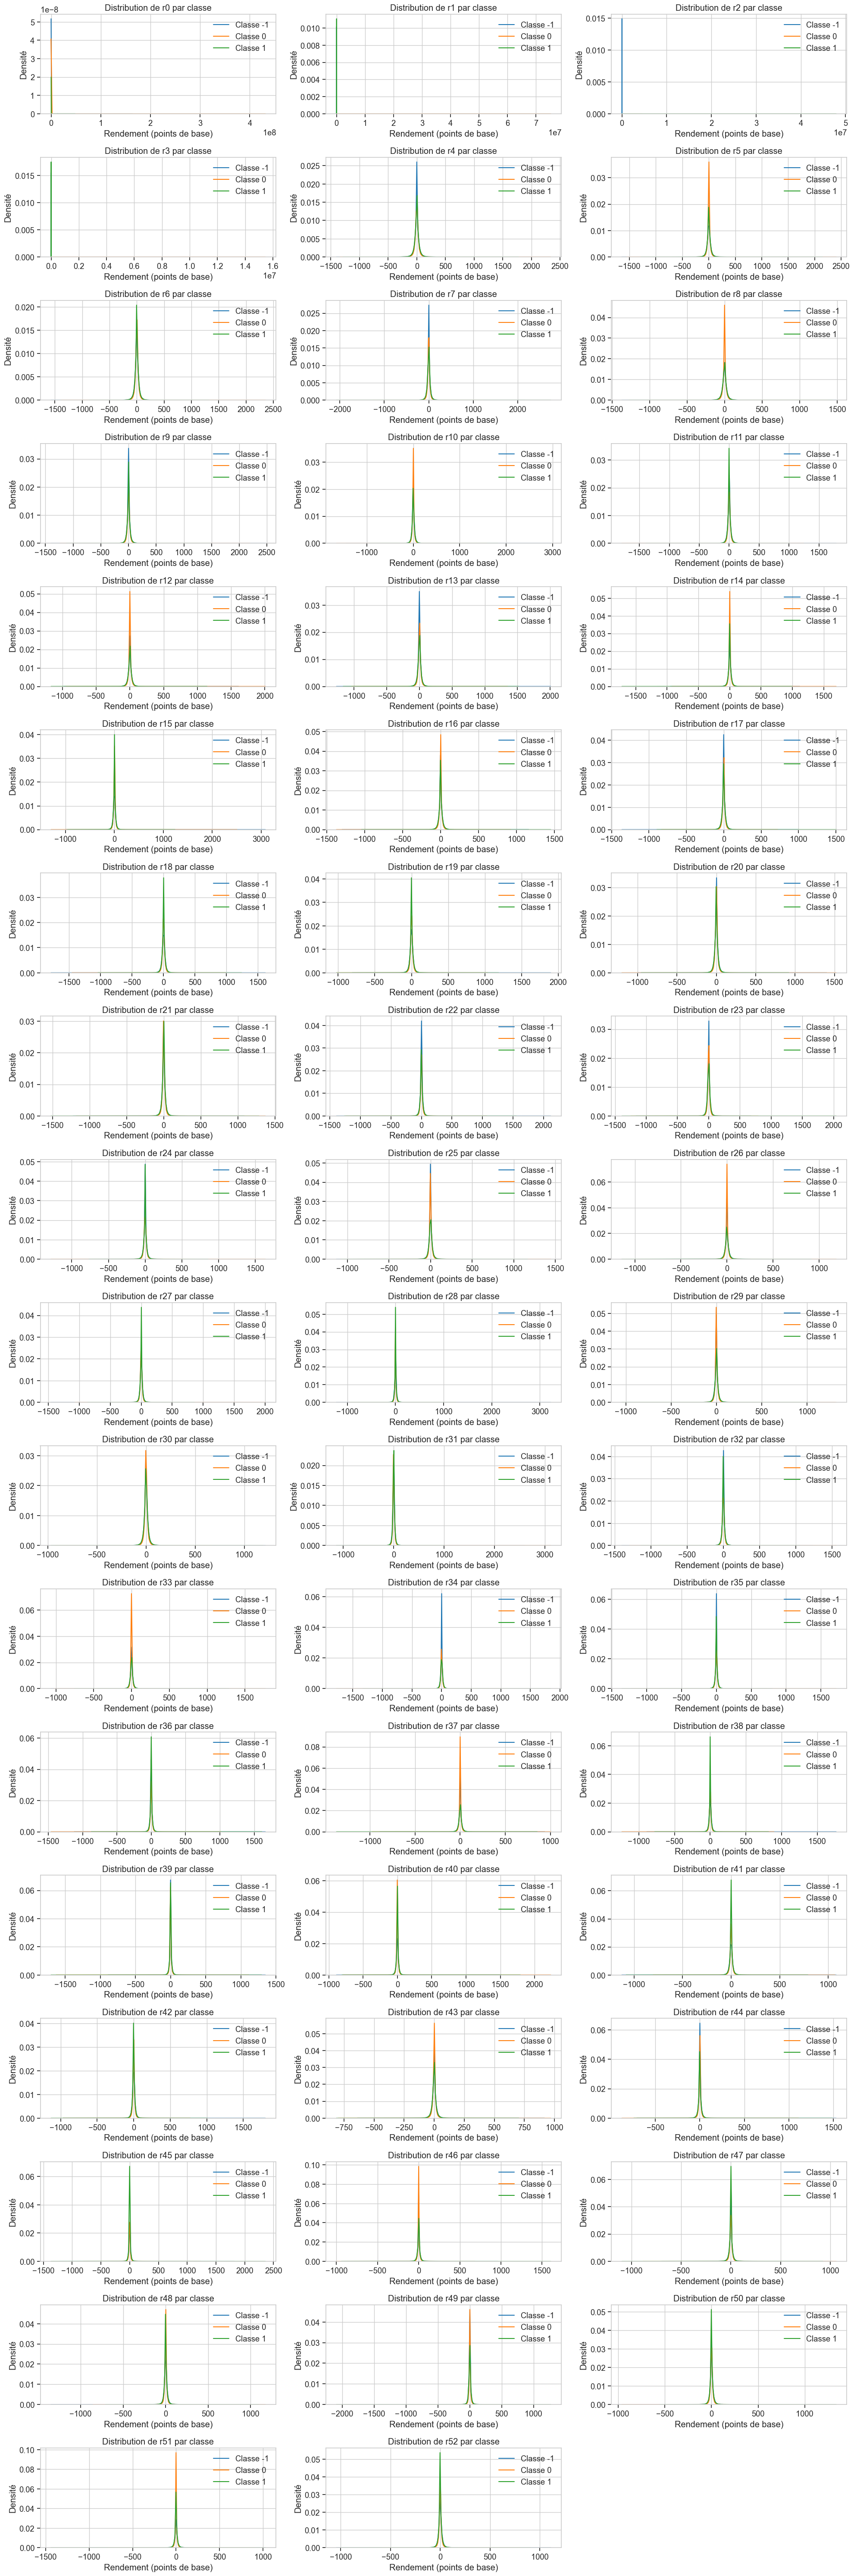

In [65]:
# Analyse des rendements par classe
plt.figure(figsize=(20,60))

for i, col in enumerate(col_rendements):
    
    plt.subplot(int(len(col_rendements)/3) + 1, 3, i+1)
    for cls in sorted(X_train['reod'].unique()):
        subset = X_train[X_train['reod'] == cls][col].dropna()
        sns.kdeplot(subset, label=f'Classe {cls}')
    plt.title(f'Distribution de {col} par classe')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Densité')
    plt.legend()
    
plt.tight_layout()
plt.show()

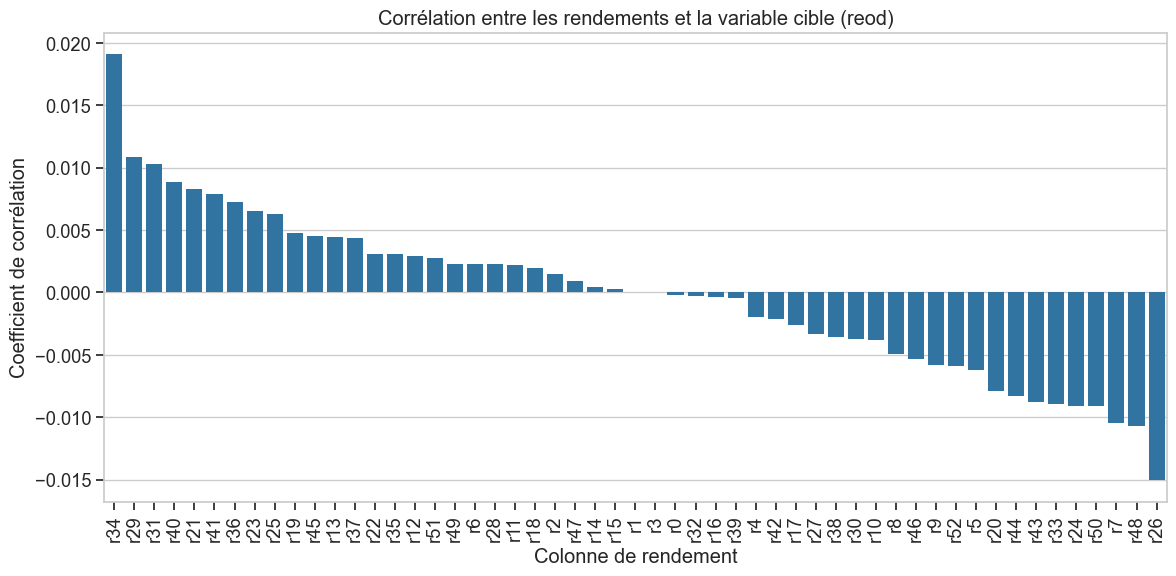

Top 5 des rendements positivement corrélés avec reod:


r34    0.019112
r29    0.010815
r31    0.010292
r40    0.008857
r21    0.008309
Name: reod, dtype: float64


Top 5 des rendements négativement corrélés avec reod:


r24   -0.009070
r50   -0.009138
r7    -0.010481
r48   -0.010694
r26   -0.015045
Name: reod, dtype: float64

In [66]:
# Corrélation entre les rendements et la variable cible
correlations = X_train[col_rendements + ['reod']].corr()['reod'].drop('reod').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Corrélation entre les rendements et la variable cible (reod)')
plt.xticks(rotation=90)
plt.xlabel('Colonne de rendement')
plt.ylabel('Coefficient de corrélation')
plt.tight_layout()
plt.show()

print("Top 5 des rendements positivement corrélés avec reod:")
display(correlations.head())

print("\nTop 5 des rendements négativement corrélés avec reod:")
display(correlations.tail())

## 3. Stratégies d'imputation

Face au défi des valeurs manquantes, nous testons plusieurs stratégies d'imputation pour compléter les données.

- 1 :  Forward-fill puis backward-fill (FFBF)

Cette stratégie propage d'abord les dernières valeurs connues vers l'avant, puis remplit les valeurs restantes en propageant depuis la fin.|

- 2 : Backward-fill puis forward-fill (BFFF)

Cette stratégie inverse commence par propager depuis la fin, puis remplit les valeurs restantes en propageant depuis le début.


- 3 : Interpolation linéaire

Cette méthode crée une ligne droite entre les valeurs connues pour estimer les valeurs manquantes.

- 4 : Imputation par K plus proches voisins (KNN)

Cette méthode utilise les K observations les plus similaires pour estimer les valeurs manquantes.

- 5 : MICE 


In [ ]:
from utils.data_registry import DATASETS
from utils.features import add_features
from utils.benchmarks import get_models
from utils.experiment_runner import run_experiment, display_experiment_result, add_result
from utils.load_data import load_datasets
from utils.graphic import analyze_distributions, compare_column_stats, analyze_normalization
from utils.variance_analysis import perform_pca_analysis, perform_tsne_analysis, analyze_correlations, evaluate_feature_sets, analyze_feature_importance, select_best_features, summarize_feature_analysis

# Create empty results tracker
results_tracker = pd.DataFrame(columns=[
    "dataset", "dataset_description", "model", "model_description", 
    "features_added", "feature_sets", "accuracy", "precision_weighted", 
    "recall_weighted", "f1_weighted"
])

# Charger les datasets
imputed_datasets = load_datasets()


Chargement du dataset raw...


In [ ]:
analyze_distributions(imputed_datasets)


### 3.2 Comparaison des stratégies d'imputation

Nous comparons les distributions après imputation pour évaluer l'impact de chaque méthode.


In [ ]:
stats_results = compare_column_stats(imputed_datasets)

### 3.3 Différentes méthodes de normalisation : 

In [ ]:
# Analyser l'impact des différentes méthodes de normalisation
normalization_results = analyze_normalization(imputed_datasets)


## 4. Modèles de référence (benchmarks)

Nous établissons des modèles de base pour servir de références aux futures améliorations.


In [ ]:
print("\nDatasets disponibles:")
for key, info in DATASETS.items():
    print(f"- {key}: {info['description']}")

print("\nModèles disponibles:")
models = get_models()
for key, info in models.items():
    if 'description' in info:
        print(f"- {key}: {info['description']}")
    else:
        print(f"- {key}")


### 4.1 Configuration des expériences



### 4.2 XGBoost baseline

Le gradient boosting est souvent efficace pour les données tabulaires et gère bien les valeurs manquantes.


In [ ]:
print("\n--- Baseline XGBoost sur données brutes ---")
baseline_result = run_experiment(dataset_key="raw", model_key="xgboost_baseline", add_feat=False)
results_tracker = add_result(results_tracker, baseline_result)
print("\nRésultats détaillés de l'expérience baseline:")
display_experiment_result(baseline_result)


--- Baseline XGBoost sur données brutes ---


KeyboardInterrupt: 

In [ ]:
print("\n--- Comparaison des stratégies d'imputation avec XGBoost ---")

imputation_strategies = ["raw", "ffbf", "bfff", "interp","knn","mice"]
imputation_results = []

for strategy in imputation_strategies:
    print(f"\nTesting {strategy} imputation...")
    try:
        # Sans feature engineering
        result_without_features = run_experiment(dataset_key=strategy, model_key="xgboost_baseline", add_feat=False)
        results_tracker = add_result(results_tracker, result_without_features)
        imputation_results.append(result_without_features)
        print(f"Accuracy without feature engineering: {result_without_features['accuracy']:.4f}")
        
        # Avec feature engineering
        result_with_features = run_experiment(dataset_key=strategy, model_key="xgboost_baseline", add_feat=True)
        results_tracker = add_result(results_tracker, result_with_features)
        imputation_results.append(result_with_features)
        print(f"Accuracy with feature engineering: {result_with_features['accuracy']:.4f}")
        
        # Amélioration due au feature engineering
        improvement = result_with_features['accuracy'] - result_without_features['accuracy']
        print(f"Improvement from feature engineering: {improvement:.4f} ({improvement*100:.2f}%)")
    except Exception as e:
        print(f"Error processing {strategy} dataset: {e}")

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='dataset', y='accuracy', hue='features_added', 
            data=results_tracker[results_tracker['model'] == 'xgboost_baseline'])
plt.title('Comparaison des stratégies d\'imputation avec XGBoost')
plt.xlabel('Stratégie d\'imputation')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Features ajoutées')
plt.tight_layout()
plt.show()

### 4.3 Régression logistique

Un modèle linéaire simple pour établir une référence de base.


In [ ]:
for strategy in imputation_strategies:
    try:
        result = run_experiment(dataset_key=strategy, model_key="logistic", add_feat=True)
        results_tracker = add_result(results_tracker, result)
        print(f"Logistic regression on {strategy}: Accuracy = {result['accuracy']:.4f}")
    except Exception as e:
        print(f"Error with logistic regression on {strategy}: {e}")
        
# Comparer les performances des modèles sur les différentes stratégies d'imputation
plt.figure(figsize=(14, 8))
sns.barplot(x='dataset', y='accuracy', hue='model', 
            data=results_tracker[results_tracker['features_added'] == True])
plt.title('Comparaison des modèles sur différentes stratégies d\'imputation')
plt.xlabel('Stratégie d\'imputation')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


### 4.4 Comparaison des benchmarks sur les différentes stratégies d'imputation



In [ ]:
# 4.6 Analyse des résultats
print("\n--- Analyse des résultats ---")

# Trouver le meilleur résultat global
best_result = results_tracker.loc[results_tracker['accuracy'].idxmax()]
print(f"\nMeilleur résultat global:")
print(f"Dataset: {best_result['dataset']} ({best_result['dataset_description']})")
print(f"Model: {best_result['model']} ({best_result['model_description']})")
print(f"Features Added: {best_result['features_added']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Weighted F1-Score: {best_result['f1_weighted']:.4f}")

# Comparaison des stratégies d'imputation
print("\nComparaison des stratégies d'imputation (avec XGBoost):")
imputation_comparison = results_tracker[
    (results_tracker['model'] == 'xgboost_baseline') & 
    (results_tracker['features_added'] == True)
].sort_values('accuracy', ascending=False)

for _, row in imputation_comparison.iterrows():
    print(f"{row['dataset']}: Accuracy = {row['accuracy']:.4f}, F1 = {row['f1_weighted']:.4f}")

# Performance vs Temps
plt.figure(figsize=(12, 8))
plt.scatter(results_tracker['total_time'], results_tracker['accuracy'], 
            c=results_tracker['dataset'].astype('category').cat.codes, 
            s=100, alpha=0.7)
plt.xlabel('Temps total d\'exécution (secondes)')
plt.ylabel('Accuracy')
plt.title('Performance vs. Temps d\'exécution')
plt.grid(True)
plt.colorbar(label='Dataset')
plt.tight_layout()
plt.show()

## 5. Analyse  des features

Après avoir établi des benchmarks, nous cherchons à améliorer les performances en analysant et en créant de nouvelles features.

### 5.1 Analyse en composantes principales (PCA)

La PCA nous aide à comprendre la structure des données et à réduire la dimensionnalité.


In [ ]:
# Effectuer l'analyse PCA sur le dataset ayant donné les meilleurs résultats
# Selon les benchmarks, utiliser le dataset avec la meilleure performance
best_dataset = "ffbf"  # À remplacer par le dataset ayant donné les meilleurs résultats
pca_results = perform_pca_analysis(dataset_key=best_dataset, sample_size=50000)


### 5.2 Visualisation t-SNE


In [ ]:
# Effectuer l'analyse t-SNE sur le dataset ayant donné les meilleurs résultats
tsne_results = perform_tsne_analysis(dataset_key=best_dataset, sample_size=5000)


### 5.3 Analyse des corrélations

Identifions les features redondantes pour simplifier nos modèles.


In [ ]:
# Effectuer l'analyse des corrélations
correlation_results = analyze_correlations(dataset_key=best_dataset)


### 5.4 Evaluation de différents ensembles de features. 
Créons des features dérivées pour capturer des motifs complexes dans les rendements.


In [ ]:

# Évaluer les différents ensembles de features
feature_evaluation = evaluate_feature_sets(dataset_key=best_dataset)

### 5.5 Analyse des features les plus pertinentes

In [ ]:
# Analyser l'importance des features sur le meilleur dataset
feature_importance, model = analyze_feature_importance(dataset_key=best_dataset, add_features=True, 
                                                     feature_sets=["basic_stats", "technical"])


### 5.6  Analyse des meilleures features

In [ ]:
# Sélectionner les meilleures features
best_features = select_best_features(feature_importance, threshold=0.01)

### Résumé 

In [ ]:
summarize_feature_analysis(pca_results, correlation_results, feature_importance, best_features)

## 6. Modèles optimisés

Avec nos nouvelles insights et features, améliorons nos modèles.

### 6.1 Sélection des features optimales



```python
# Code pour la sélection de features
```


### 6.2 Optimisation des hyperparamètres



```python
# Code pour l'optimisation
```



### 6.3 Comparaison avec les benchmarks

```python
# Code pour la comparaison
```


## 7. Méthodes avancées

Explorons des approches plus sophistiquées pour améliorer encore les performances.

### 7.1 Clustering non supervisé



### 7.2 Modèles ensemblistes avancés


```python
# Code pour les modèles ensemblistes
```



## 8. Interprétabilité des modèles

Analysons comment nos modèles prennent leurs décisions.

### 8.1 SHAP values



```python
# Code pour SHAP
```


### 8.2 Analyse des erreurs





## 9. Conclusion

### 9.1 Synthèse des résultats

### 9.2 Recommandations

### 9.3 Perspectives futures